# 四. 建模和调参
本次任务中比较大的收获是以下几点：
1. 学习了模型性能验证相关函数
2. 了解XGBoost和lightgbm算法原理的使用方法
3. 了解了模型自动调参过程，学会了贝叶斯调参这个高效的工具，尤其是在和网格调参对比时  

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """reduce memory usage by modify the type of data
    """
    start_mem = df.memory_usage().sum()
    print("memmory usage brefore reduce:{:.2f}MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum()
    print("memmory usage after reduce:{:.2f}MB".format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('data/data_for_tree.csv'))

memmory usage brefore reduce:60507376.00MB
memmory usage after reduce:15724155.00MB
Decreased by 74.0%


In [4]:
pd.set_option('display.max_columns', None)
sample_feature

,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,seller,offerType,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,0,0,1850.0,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551,1,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
1,2262,40.0,1,2.0,0.0,0.0,0,15.0,-,0,0,3600.0,45.31250,5.234375,0.137939,1.380859,-1.421875,0.264893,0.121033,0.135742,0.026596,0.020584,-4.902344,2.095703,-1.030273,-1.722656,0.245483,1,4756.0,4.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,NaN
2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,0,0,6222.0,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980,1,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,0,0,2400.0,45.68750,4.492188,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000,-4.507812,1.286133,-0.501953,-2.437500,-0.478760,1,7124.0,NaN,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,19.0
4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,0,0,5200.0,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828,1,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15414322.0,3344.0,3306.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199032,20903,4.0,4,4.0,0.0,0.0,116,15.0,0.0,0,0,NaN,45.62500,5.957031,-0.918457,0.774902,-2.021484,0.284668,0.130005,0.049835,0.028809,0.004616,-5.976562,1.302734,-1.207031,-1.981445,-0.357666,0,7260.0,3.0,16576.0,99999.0,6000.0,12.0,138279072.0,8088.0,8344.0,11.0
199033,708,0.0,0,0.0,0.0,0.0,75,15.0,0.0,0,0,NaN,43.93750,4.476562,-0.841797,1.328125,-1.292969,0.268066,0.108093,0.066040,0.025467,0.025970,-3.914062,1.759766,-2.076172,-1.155273,0.169067,0,6016.0,1.0,31424.0,68500.0,3200.0,13.0,173719696.0,6260.0,5528.0,7.0
199034,6693,49.0,1,0.0,1.0,1.0,224,15.0,0.0,0,0,NaN,46.53125,4.171875,0.388672,-0.704590,-1.480469,0.269531,0.105713,0.117676,0.057465,0.015671,-4.640625,0.654785,1.137695,-1.390625,0.254395,0,4344.0,3.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,22.0
199035,96900,27.0,1,0.0,0.0,1.0,334,15.0,0.0,0,0,NaN,46.78125,-3.296875,0.243530,-1.277344,-0.404785,0.261230,0.000490,0.137329,0.086243,0.051392,1.833984,-2.828125,2.464844,-0.911621,-2.056641,0,NaN,1.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,NaN


In [5]:
sample_feature.model.value_counts()

0.0      15639
19.0     12640
4.0      11433
1.0       7907
29.0      6922
         ...  
244.0        4
245.0        4
240.0        3
242.0        3
247.0        1
Name: model, Length: 248, dtype: int64

In [6]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model']]

## dropna()
```python
import pandas as pd
# 删除含有空数据的全部行
df4 = pd.read_csv('4.csv',  encoding='utf-8')
df4 = df4.dropna()
# 可以通过axis参数来删除含有空数据的全部列
df4 = df4.dropna(axis=1)
# 可以通过subset参数来删除在age和sex中含有空数据的全部行
df4 = df4.dropna(subset=["age", "sex"])
df4 = df4.dropna(subset=['age', 'body','home.dest'])
```
## reset_index()
DataFrame.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')

参数解释:

level：int、str、tuple或list，默认无，仅从索引中删除给定级别。默认情况下移除所有级别。控制了具体要还原的那个等级的索引 

drop：drop为False则索引列会被还原为普通列，否则会丢失

inplace：默认为false，适当修改DataFrame(不要创建新对象)

col_level：int或str，默认值为0，如果列有多个级别，则确定将标签插入到哪个级别。默认情况下，它将插入到第一级。

col_fill：对象，默认‘’，如果列有多个级别，则确定其他级别的命名方式。如果没有，则重复索引名
## set_index()
set_index():
函数原型：DataFrame.set_index(keys, drop=True, append=False, inplace=False, verify_integrity=False) 

参数解释：

keys：列标签或列标签/数组列表，需要设置为索引的列

drop：默认为True，删除用作新索引的列

append：默认为False，是否将列附加到现有索引

inplace：默认为False，适当修改DataFrame(不要创建新对象)

verify_integrity：默认为false，检查新索引的副本。否则，请将检查推迟到必要时进行。将其设置为false将提高该方法的性能。

In [7]:
sample_feature = sample_feature.dropna().replace('-', 0 )
sample_feature

,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,seller,offerType,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,0,0,1850.0,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551,1,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,0,0,6222.0,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980,1,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,0,0,5200.0,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828,1,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15414322.0,3344.0,3306.0,6.0
5,137642,24.0,10,0.0,1.0,0.0,109,10.0,0.0,0,0,8000.0,46.31250,-3.228516,0.156616,-1.727539,-0.345703,0.260254,0.000518,0.119812,0.090942,0.048767,1.885742,-2.722656,2.457031,-0.286865,0.206543,1,2482.0,3.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,10.0
6,2402,13.0,4,0.0,0.0,1.0,150,15.0,0.0,0,0,3500.0,46.09375,4.925781,0.113281,1.644531,-1.270508,0.268066,0.117676,0.142334,0.025452,0.028168,-4.902344,1.610352,-0.834473,-1.996094,-0.103210,1,6184.0,3.0,16576.0,99999.0,6000.0,12.0,138279072.0,8088.0,8344.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149031,43073,42.0,1,1.0,0.0,0.0,122,3.0,0.0,0,0,14780.0,47.06250,4.734375,1.851562,-1.884766,1.219727,0.235107,0.114624,0.170288,0.080322,0.091736,-5.136719,1.442383,2.812500,0.951172,-1.600586,1,1538.0,5.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,12.0
149032,163978,121.0,10,4.0,0.0,1.0,163,15.0,0.0,0,0,5900.0,45.31250,-3.138672,-1.269531,-0.736816,-1.505859,0.280273,0.000310,0.048431,0.071167,0.019180,1.988281,-2.984375,0.589355,-1.304688,-0.302490,1,5772.0,4.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,16.0
149033,184535,116.0,11,0.0,0.0,0.0,125,10.0,0.0,0,0,9500.0,45.96875,-3.144531,-0.023529,-2.367188,0.698242,0.253174,0.000777,0.084106,0.099670,0.079346,1.838867,-2.775391,2.554688,0.924316,-0.272217,1,2322.0,2.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,12.0
149034,147587,60.0,11,1.0,1.0,0.0,90,6.0,0.0,0,0,7500.0,44.71875,-3.105469,0.595215,-2.279297,1.423828,0.233398,0.000705,0.118896,0.100098,0.097900,2.439453,-1.630859,2.291016,1.891602,0.415039,1,2003.0,3.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,8.0


In [8]:
sample_feature = sample_feature.reset_index(drop=True)   
#不加上面一句绘图时会报错
sample_feature

,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,seller,offerType,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_amount,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_average,power_bin
0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,0,0,1850.0,43.34375,3.966797,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473,-2.880859,2.804688,-2.419922,0.795410,0.914551,1,4384.0,1.0,10192.0,35990.0,1800.0,13.0,36457520.0,4564.0,3576.0,5.0
1,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,0,0,6222.0,45.96875,4.824219,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069,-4.847656,1.803711,1.565430,-0.832520,-0.229980,1,4384.0,2.0,1458.0,45000.0,8496.0,100.0,14373814.0,5424.0,9848.0,16.0
2,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,0,0,5200.0,44.37500,2.031250,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521,-1.896484,0.910645,0.931152,2.833984,1.923828,1,1531.0,6.0,4664.0,31500.0,2300.0,20.0,15414322.0,3344.0,3306.0,6.0
3,137642,24.0,10,0.0,1.0,0.0,109,10.0,0.0,0,0,8000.0,46.31250,-3.228516,0.156616,-1.727539,-0.345703,0.260254,0.000518,0.119812,0.090942,0.048767,1.885742,-2.722656,2.457031,-0.286865,0.206543,1,2482.0,3.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,10.0
4,2402,13.0,4,0.0,0.0,1.0,150,15.0,0.0,0,0,3500.0,46.09375,4.925781,0.113281,1.644531,-1.270508,0.268066,0.117676,0.142334,0.025452,0.028168,-4.902344,1.610352,-0.834473,-1.996094,-0.103210,1,6184.0,3.0,16576.0,99999.0,6000.0,12.0,138279072.0,8088.0,8344.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91724,43073,42.0,1,1.0,0.0,0.0,122,3.0,0.0,0,0,14780.0,47.06250,4.734375,1.851562,-1.884766,1.219727,0.235107,0.114624,0.170288,0.080322,0.091736,-5.136719,1.442383,2.812500,0.951172,-1.600586,1,1538.0,5.0,13656.0,84000.0,6400.0,15.0,124044600.0,8992.0,9080.0,12.0
91725,163978,121.0,10,4.0,0.0,1.0,163,15.0,0.0,0,0,5900.0,45.31250,-3.138672,-1.269531,-0.736816,-1.505859,0.280273,0.000310,0.048431,0.071167,0.019180,1.988281,-2.984375,0.589355,-1.304688,-0.302490,1,5772.0,4.0,13992.0,92900.0,5200.0,15.0,113034208.0,8248.0,8076.0,16.0
91726,184535,116.0,11,0.0,0.0,0.0,125,10.0,0.0,0,0,9500.0,45.96875,-3.144531,-0.023529,-2.367188,0.698242,0.253174,0.000777,0.084106,0.099670,0.079346,1.838867,-2.775391,2.554688,0.924316,-0.272217,1,2322.0,2.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,12.0
91727,147587,60.0,11,1.0,1.0,0.0,90,6.0,0.0,0,0,7500.0,44.71875,-3.105469,0.595215,-2.279297,1.423828,0.233398,0.000705,0.118896,0.100098,0.097900,2.439453,-1.630859,2.291016,1.891602,0.415039,1,2003.0,3.0,2944.0,34500.0,2900.0,30.0,13398006.0,4724.0,4548.0,8.0


In [9]:
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_Y = train['price']

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
train.used_time

0        4384.0
1        4384.0
2        1531.0
3        2482.0
4        6184.0
          ...  
91724    1538.0
91725    5772.0
91726    2322.0
91727    2003.0
91728    3672.0
Name: used_time, Length: 91729, dtype: float64

In [12]:
model = LinearRegression(normalize=True)
model = model.fit(train_X,train_Y)

In [13]:
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367077.440622087),
 ('v_8', 700656.3543473142),
 ('v_9', 170626.24091390774),
 ('v_7', 32318.173103539906),
 ('v_12', 20480.562677912425),
 ('v_3', 17871.47564682066),
 ('v_11', 11482.123138838124),
 ('v_13', 11263.399851889584),
 ('v_10', 2681.353980717116),
 ('gearbox', 881.8328203287064),
 ('fuelType', 363.9024737408447),
 ('bodyType', 189.5855271618431),
 ('city', 44.95362239827704),
 ('power', 28.55762736999318),
 ('brand_price_median', 0.5103099160113326),
 ('brand_price_std', 0.450327554686591),
 ('brand_amount', 0.14881138893608187),
 ('brand_price_max', 0.0031902053613159786),
 ('offerType', 9.991461411118507e-06),
 ('train', 1.2665987014770508e-07),
 ('seller', -4.952307790517807e-07),
 ('brand_price_sum', -2.175000814125975e-05),
 ('name', -0.00029815823324315876),
 ('used_time', -0.0025261487755900086),
 ('brand_price_average', -0.40481959754456004),
 ('brand_price_min', -2.246718360060368),
 ('power_bin', -34.45676039714125),
 ('v_14', -274.91399236938065),
 ('ki

In [14]:
import matplotlib.pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_Y), size=50)


The predicted price is obvious different from true price


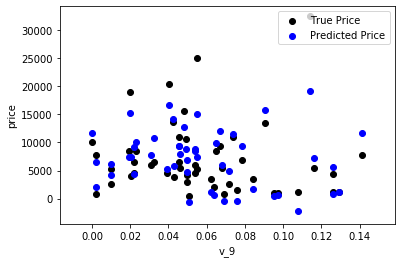

In [15]:
plt.scatter(train_X['v_9'][subsample_index], train_Y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

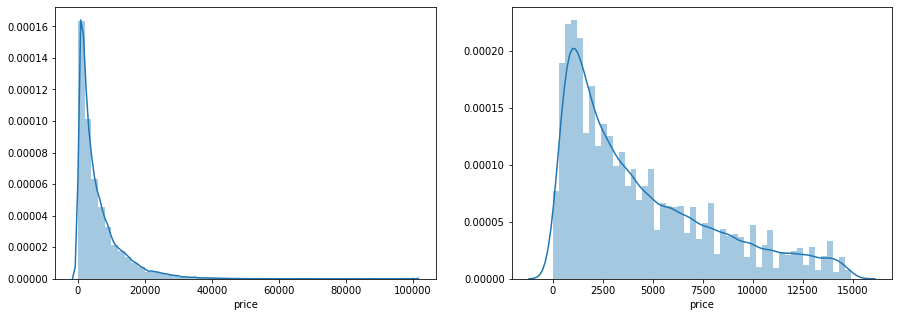

In [16]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(train_Y)
plt.subplot(1,2,2)
sns.distplot(train_Y[train_Y < train_Y.quantile(0.9)])

In [17]:
train_Y.quantile(0.9)

14900.0

In [18]:
train_Y.max()

99999.0

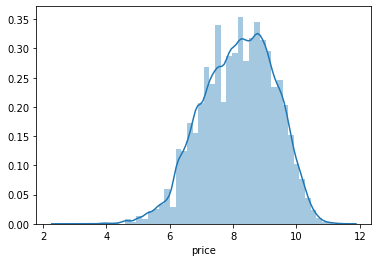

In [19]:
train_Y_ln = np.log(train_Y+1)
sns.distplot(train_Y_ln)

In [20]:
modle = model.fit(train_X, train_Y_ln)

In [21]:
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key = lambda x:x[1], reverse=False)

[('v_6', -238.78518046193227),
 ('v_8', -40.35060772203902),
 ('v_10', -1.6271621034419863),
 ('v_2', -0.9504899086266602),
 ('v_4', -0.8320763999810545),
 ('notRepairedDamage', -0.2702944026708827),
 ('kilometer', -0.013835903630346084),
 ('v_14', -0.004285615931517726),
 ('city', -0.0022172506125159573),
 ('used_time', -4.126537154502966e-06),
 ('name', -7.021723724214246e-08),
 ('brand_price_sum', -1.5124108565174435e-10),
 ('seller', -4.263256414560601e-11),
 ('offerType', -1.0182077403442236e-11),
 ('train', 3.637978807091713e-12),
 ('brand_price_max', 6.191737965170092e-07),
 ('brand_price_average', 6.336678789907191e-07),
 ('brand_price_std', 6.517052329786106e-07),
 ('brand_price_median', 1.2322281792530338e-06),
 ('brand_amount', 2.8979529047956687e-06),
 ('brand_price_min', 3.336606209897191e-05),
 ('power', 0.0007176637371206563),
 ('bodyType', 0.004516720629713759),
 ('fuelType', 0.006684066538358102),
 ('gearbox', 0.007926459579122459),
 ('power_bin', 0.008483677741707064)

The predicted price is obvious different from true price


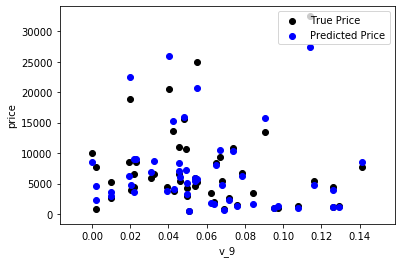

In [22]:
plt.scatter(train_X['v_9'][subsample_index], train_Y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

# 五折交叉验证
为了避免过拟合，将训练集中的一部分取出来当作评估级，对训练生成的参数进行测试
## sklearn中的cross_val_score()函数
```python
sklearn.cross_validation.cross_val_score(estimator, X, y=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)
```
### 参数
estimator：数据对象  
X：数据  
y：预测数据  
soring：调用的方法  
cv：交叉验证生成器或可迭代的次数   
n_jobs：同时工作的cpu个数（-1代表全部）  
verbose：详细程度   
fit_params：传递给估计器的拟合方法的参数  
pre_dispatch：控制并行执行期间调度的作业数量。减少这个数量对于避免在CPU发送更多作业时CPU内存消耗的扩大是有用的。该参数可以是：  
· 没有，在这种情况下，所有的工作立即创建并产生。将其用于轻量级和快速运行的作业，以避免由于按需产生作业而导致延迟  
· 一个int，给出所产生的总工作的确切数量  
· 一个字符串，给出一个表达式作为n_jobs的函数，如'2 * n_jobs'

-----------------------------------------------------------------------------------------
**scoring**
指定在进行网格搜索或者计算交叉验证得分的时候，使用什么标准度量'estimator'的预测性能，默认是None，就是使用estimator自己的score方法来计算得分。我们可以指定别的性能度量标准，它必须是一个可调用对象，sklearn.metrics不仅为我们提供了一系列预定义的可调用对象，而且还支持自定义评估标准  

Scoring	| Function
:-: | :-:
分类
accuracy | metrics.accuracy_score
average_precision | metrics.average_precision_score
f1 | metrics.f1_score
f1_micro | metrics.f1_score
f1_macro | metrics.f1_score
f1_weighted | metrics.f1_score
f1_sample | metrics.f1_score
neg_log_loss | metrics.log_loss
precision | metrics.precision_score
recall | metrics.recall_score
roc_auc | metrics.roc_auc_score
聚类
adjusted_rand_score | metrics.adjusted_rand_score
回归
neg_mean_absolute_erroe | metrics.neg_mean_absolute_erroe
neg_mean_squared_error	| metrics.neg_mean_squared_error
neg_median_absolute_error | metrics.neg_median_absolute_error
r2 | metrics.r2  

可以使用sklearn.metrics.SCORERS返回以上的评估函数。

在交叉验证中使用自定义scoring参数

1. 把sklearn.metrics中已有的度量指标封装成符合‘scoring’参数要求的形式。
Metrics模块中的很多的度量方法并没有被分配‘scoring’参数可用的名字。因为这些度量指标需要附加参数，比如：‘fbeta_score’。在这种情况下，如果我们想要使用‘fbeta_score’的话，必须要产生一个合适的scoring对象，产生可调用对象的最简单的方法就是使用‘make_scorer’,该函数会把'fbeta_score'这个函数转换成能够在模型评估中使用的可调用对象。
```python
from sklearn.metrics import fbeta_score, make_scorer
ftwo_score = make_scorer(fbeta_score, beta=2)  # 添加参数
from sklearn.model_selection import  GridSearchCV
from sklearn.svm import LinearSVC
grid = GridSearchCV(LinearSVC(), param_grid={'C': [1,10]}, scoring=ftwo_score)
```
2. 完全自定义自己的度量指标然后用'make_scorer'函数转换成符合’scoring‘参数要求的形式
```python
from sklearn.metrics import fbeta_score, make_scorer
import numpy as np
def my_custom_loss_func(ground_truth, predictions):
    diff = np.abs(ground_truth - predictions).max()
    return np.log(1 + diff)
loss = make_scorer(my_custom_loss_func, greater_is_better = False)
score = make_scorer(my_custom_loss_func, greater_is_better = False)
ground_truth = [[1,1]]
predictions = [0,1]
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(strategy='most_frequent', random_state = 0)
clf = clf.fit(ground_truth, predictions)
print(loss(clf, ground_truth, predictions))
print(score(clf, ground_truth, predictions))
```

链接：https://www.jianshu.com/p/62898becbdd6

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper
scores = cross_val_score(model, X=train_X, y=train_Y, verbose=1, cv=5,
                         scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [30]:
np.mean(scores)

1.365429593439605

In [43]:
scores = cross_val_score(model, X=train_X, y=train_Y_ln, cv=10,
                         scoring=make_scorer(mean_absolute_error))
np.mean(scores)
scores = pd.DataFrame(scores.reshape(1, -1))

In [45]:

scores.columns = ['cv' + str(i)for i in range(1,11)]
scores.index = ['MAE']
scores


,cv1,cv2,cv3,cv4,cv5,cv6,cv7,cv8,cv9,cv10
MAE,0.192506,0.189079,0.192535,0.194544,0.195518,0.192999,0.192239,0.191254,0.196311,0.195275


由于实际情况下只能根据历史价格预测之后价格，所以五折交叉验证很多情况下并不成立
可以选择将前五分之四时间的样本用作训练集，后五分之一时间样本用做测试集



In [47]:
import datetime
sample_feature = sample_feature.reset_index(drop=True)

In [48]:
split_point = len(sample_feature) //  5 * 4
split_point

73380

In [53]:
train = sample_feature[:split_point]
val = sample_feature[split_point:]
train_X = train[continuous_feature_names]
train_Y_ln =  np.log(train['price']+1)
val_X = val[continuous_feature_names]
val_Y_ln = np.log(val['price']+1)

model = model.fit(train_X, train_Y_ln)
mean_absolute_error(val_Y_ln, model.predict(val_X))

0.1956667583578214

# 绘制学习率和验证曲线


In [54]:
from sklearn.model_selection import learning_curve, validation_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\achan\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

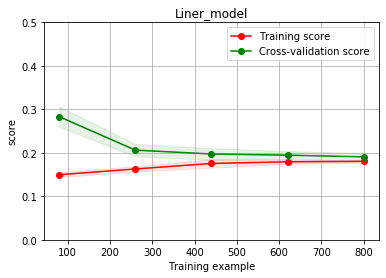

In [56]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_Y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

# 多种模型对比
## 线性模型特征选择
task03中的嵌入式和过滤式特征选择过程和训练过程是分隔开的，本节学习的**嵌入式特征选择**（正则化）则在训练中自动进行特征选择，之前看到的正则化是在目标函数中加入惩罚项。对线性回归加入两种正则化方法后（L1和L2正则化），分别变成Lasso回归和岭回归  
[参考链接](https://www.cnblogs.com/Belter/p/8536939.html)
[参考链接](https://blog.csdn.net/weixin_43374551/article/details/83688913)  
L1正则化（Lasso）趋向于对特征进行筛选
L2正则化（岭回归）趋向于构造一个系数比较小的模型

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

models = [LinearRegression(),
          Ridge(),
          Lasso()]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_Y_ln, verbose=0, cv = 5,
                             scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
    
    result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression is finished
Ridge is finished
Lasso is finished


,LinearRegression,Ridge,Lasso
cv1,0.190308,0.194218,0.383479
cv2,0.193322,0.197299,0.383605
cv3,0.192814,0.196633,0.383384
cv4,0.193281,0.197049,0.382751
cv5,0.191888,0.195739,0.379179


## XGBoost
```python
clf1 = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
```
### 参数说明
[参考链接](https://www.jianshu.com/p/7aab084b7f47)  
 参数解释
我们看到在建立xgboost的模型时，有很多参数，这些参数是什么意思呢，我们来看一下。 

---------------------------------------
一般参数
这些参数用来控制XGBoost的整体功能，是一些通用的设置，有的时候都不用调整。
（1）booster[默认gbtree]  
每次迭代的模型选择，有两个gbtree：基于树的模型和gbliner：线性模型，显然我们一般都会选择gbtree。 
（2）silent[默认0]  
是否开启静默模式，0为不开启，1为开启，开启后不输出任何信息，显然这不利于我们调参，默认选0就好了。  
（3）nthread[默认取最大线程数]  
这个参数用来控制最大并行的线程数，如果你希望取得所有CPU的核，那么你就不用管它。  

------------------------------------

booster参数或者说树的参数  
这些参数是要重点调整的，比较重要，主要是用来控制每一步树的生成。  
（1）eta [default=0.3]  
学习率参数，就是原理中说的缩减，保证每一颗树对于结果的影响不太大，从而保证模型的效果。更新叶子节点权重时，乘以该系数，避免步长过大。参数值越大，越可能无法收敛。把学习率 eta 设置的小一些，小学习率可以使得后面的学习更加仔细。 典型值为0.01-0.2。  
（2）min_child_weight [default=1]  
大家对他的解释是决定最小叶子节点样本权重和，不太好理解。看了一些解释的文章，这个值可以理解为H值，还记得H值吗，就是损失函数对y(t-1)的二阶导数和，那么如果损失函数是平方函数（回归问题），这个就是1，如果是对数损失函数（分类问题），导数是a(1-a)的形式，a代表sigmoid函数，这样的话当y预测值非常大的时候，这个式子的值接近于0，这当然是不好的，因此你要给他设定一个阈值，小于这个阈值就不分裂了。现在可以解释了，这个值代表所有样本二阶导数的和，和上边说的叶子得分不是一个事，如果是回归问题实际代表样本个数，如果是分类问题实际代表a(1-a)所有样本计算值的加和。  
明白这个参数是啥以后，来看他是干嘛的，这个参数用于避免过拟合，当它的值较大时，可以避免模型学习到局部的特殊样本。举个栗子来说，对正负样本不均衡时的 0-1 分类而言，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本，实际是通过控制样本数来控制过拟合的。你们应该看出来这个值越小越容易过拟合，需要通过cv进行调整优化。  
（3）max_depth [default=6]  
这个没啥好说的，每棵树的最大深度，也是用来避免过拟合的，max_depth越大，模型会学到更具体更局部的样本，典型值3-10，要用cv调优。  
（4）max_leaf_nodes  
树上最大节点的数量，和上面的那个参数一样，如果定义了这个参数就会忽略掉max_depth参数，我们调优还是以max_depth为主吧。  
（5）gamma[default=0]  
一听这种希腊字母就知道是个系数，在树的叶子节点上作进一步分区所需的最小损失减少。越大，算法越保守。取值在[0,∞] 。通俗点讲就是，这个节点还划不划分，先看看损失减不减少了再说。同样需要cv调优。  
（6）max_delta_step [default=0]  
这参数限制每棵树权重改变的最大步长。如果这个参数的值为0，那就意味着没有约束。如果它被赋予了某个正值，那么它会让这个算法更加保守。通常，这个参数不需要设置。但是当各类别的样本十分不平衡时，它对逻辑回归是很有帮助的。也就是说这个参数不用管啊。  
（7）subsample [default=1]  
样本采样用的，减小这个参数的值，算法会更加保守，避免过拟合，但是如果这个值设置得过小，它可能会导致欠拟合。典型值：0.5-1。既然有个范围，给他个面子cv调优一把吧。  
（8）colsample_bytree [default=1]  
列采样，就是选择生成树的特征，前面介绍过了，和设置缩减率一样是为了干嘛来着，是为了防止过拟合的，一般设置为： 0.5-1 ，也要用cv拟合。  
（9）colsample_bylevel[default=1]  
等一下哈，这个怎么和上面参数这么像，哦，它是在上面树的基础上，对每一级进行分裂时对列（就是特征）进行采样，大神们都说这个参数不用用了，用上面那个就行了。  
（10）lambda [default=1]   
又是个系数，这个是控制L2正则的，就是目标函数里的那个叶子节点得分前边的系数，用不用看你自己了。  
（11）alpha [default=0]  
想必你也想到了吧，有L2就有L1，用不用全凭自己了。  
（12） scale_pos_weight [default=1]  
这个是控制样本均衡与否的，如果是不均衡样本，设置一个正数可以保证快速收敛，具体为什么，也没人解释，先留着吧。  
（13）tree_method[default=’auto’]  
还记得我说过树的生成有很多方法吧，他们介绍的老复杂了，别看了，人家自动给我们打包好了，有三个可选的值， {‘auto’, ‘exact’, ‘approx’} ，分别对应 贪心算法(小数据集)/近似算法(大数据集) 。  
大概就这么多吧，如果看到了别的，我再补充。

------------------------------------------------------------------------------------------------------------------
学习目标参数  
这个是最后一类参数了，跟目标函数有关。  
（1）objective [ default=reg:linear ]  
这是返回目标函数值，这个东西包含的函数还挺多，默认是线形的。此外你还可以选择：binary:logistic 二分类的逻辑回归，返回预测的概率(不是类别)。multi:softmax 使用softmax的多分类器，返回预测的类别(不是概率)。在这种情况下，你还需要多设一个参数：num_class(类别数目)。multi:softprob 和multi:softmax参数一样，但是返回的是每个数据属于各个类别的概率。  
（2）eval_metric[默认值取决于objective参数的取值]  
也就是说怎么计算目标函数值，根据你目标函数的形式来，对于回归问题，默认值是rmse，对于分类问题，默认值是error。  
（3）seed(default=0)  
这个叫随机数种子，还记得random包里那个seed吗，这个参数就是为了可以使结果复现。  




## lightgbm
lightgbm和xgboost都是对gbdt的不同的实现方法
### LightGBM与XGBoost的联系和区别有哪些？
（1）LightGBM使用了基于histogram的决策树算法，这一点不同于XGBoost中的贪心算法和近似算法，histogram算法在内存和计算代价上都有不小优势。1）内存上优势：很明显，直方图算法因为对特征分桶后只需保存特征离散化之后的值,一般需要八位整形保存，而XGBoost的贪心算法既要保存原始feature的值，也要保存这个值的顺序索引，这些值需要32位的浮点数来保存。2）计算上的优势：预排序算法在选择好分裂特征计算分裂收益时需要遍历所有样本的特征值，时间为O(data * features)，而直方图算法只需要遍历桶就行了，时间为O(data * bins)。  
（2）XGBoost采用的是level-wise的分裂策略，而LightGBM采用了leaf-wise的策略，区别是XGBoost对每一层所有节点做无差别分裂，可能有些节点的增益非常小，对结果影响不大，但是XGBoost也进行了分裂，带来了不必要的开销。leaft-wise的做法是在当前所有叶子节点中选择分裂收益最大的节点进行分裂，如此递归进行，很明显leaf-wise这种做法容易过拟合，因为容易陷入比较高的深度中，因此需要对最大深度做限制，从而避免过拟合。  
（3）XGBoost在每一层都动态构建直方图，因为XGBoost的直方图算法不是针对某个特定的特征，而是所有特征共享一个直方图(每个样本的权重是二阶导)，所以每一层都要重新构建直方图，而LightGBM中对每个特征都有一个直方图，所以构建一次直方图就够了。  
（4）LightGBM使用直方图做差加速，一个子节点的直方图可以通过父节点的直方图减去兄弟节点的直方图得到，从而加速计算。  
（5）LightGBM支持类别特征，不需要进行独热编码处理。  
（6）LightGBM优化了特征并行和数据并行算法，除此之外还添加了投票并行方案。  
（7）LightGBM采用基于梯度的单边采样来减少训练样本并保持数据分布不变，减少模型因数据分布发生变化而造成的模型精度下降。  
（8）特征捆绑转化为图着色问题，减少特征数量。
（9）由于使用了直方图排序算法，在分裂时找到的分割点也许并不是最精确的，可能会对结果产生影响。但是由于决策树是弱模型，粗略的分割点也可以起到避免过拟合和正则化的作用。同时在梯度提升的框架下，单棵树的误差并不会对整体训练结果造成过大的影响  

```python
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary', #xentlambda
    'metric': 'auc',
    'silent':0,
    'learning_rate': 0.05,
    'is_unbalance': 'true',  #当训练数据是不平衡的，正负样本相差悬殊的时候，可以将这个属性设为true,此时会自动给少的样本赋予更高的权重
    'num_leaves': 64,  # 一般设为少于2^(max_depth)
    'max_depth': -1,  #最大的树深，设为-1时表示不限制树的深度
    'min_child_samples': 15,  # 每个叶子结点最少包含的样本数量，用于正则化，避免过拟合
    'max_bin': 200,  # 设置连续特征或大量类型的离散特征的bins的数量
    'subsample': 0.8,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.5,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    #'scale_pos_weight':100,
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 2.99,  # L1 regularization term on weights
    'reg_lambda': 1.9,  # L2 regularization term on weights
    'nthread': 10,
    'verbose': 0,
}
```


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [62]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_Y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190308,0.192879,0.142947,0.167874,362.476994,0.139569,0.142025
cv2,0.193322,0.198244,0.146924,0.171782,125.387773,0.140406,0.144867
cv3,0.192814,0.194631,0.144587,0.171428,224.187403,0.140140,0.143528
cv4,0.193281,0.195505,0.144282,0.170032,505.739741,0.140835,0.143423
cv5,0.191888,0.193627,0.142778,0.169532,465.564588,0.139402,0.143375


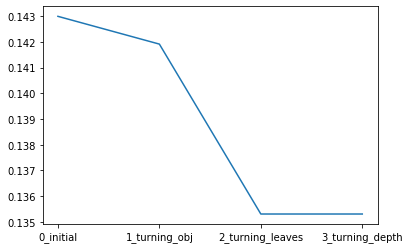

In [64]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []
train_y_ln = train_Y_ln
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5,
                                    scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5,
                                    scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5,
                                    scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score
    
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'],
             y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [66]:
from sklearn.model_selection import GridSearchCV

parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y_ln)

print(clf.best_params_)

{'max_depth': 15, 'num_leaves': 55, 'objective': 'huber'}


In [67]:
model = LGBMRegressor(objective='huber',
                          num_leaves=55,
                          max_depth=15)
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, cv=5, scoring=make_scorer(mean_absolute_error)))

0.1368675179351379

In [69]:
from bayes_opt import BayesianOptimization

def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8669   |  52.36    |  62.61    |  71.53    |  0.6849   |
|  2        |  0.8686   |  59.18    |  75.11    |  90.35    |  0.7191   |
|  3        |  0.8621   |  82.58    |  24.13    |  43.67    |  0.1636   |
|  4        |  0.8436   |  81.68    |  68.7     |  12.95    |  0.6029   |
|  5        |  0.8582   |  74.97    |  90.29    |  31.27    |  0.138    |
|  6        |  0.8261   |  3.253    |  5.416    |  94.53    |  0.3264   |
|  7        |  0.8685   |  62.51    |  73.18    |  90.77    |  0.3734   |
|  8        |  0.8175   |  3.178    |  96.08    |  5.949    |  0.3321   |
|  9        |  0.8692   |  97.85    |  4.462    |  99.89    |  0.4997   |
|  10       |  0.8688   |  99.35    |  98.06    |  94.84    |  0.6916   |
|  11       |  0.8677   |  99.83    |  47.18    |  78.26    |  0.1509   |
|  12       |  0.8262   |  3.925    | 

In [71]:
1 - rf_bo.max['target']

0.13073529960514607